**Audio dataset - Audio Emotions (Angry)**

**Initial Exploration of the Data - basic properties of the audio file**

In [ ]:
import wave

# Open the audio file
with wave.open("03-01-05-01-01-01-01.wav", "rb") as wf:
    # Extract basic properties
    n_channels = wf.getnchannels()
    sample_width = wf.getsampwidth()
    framerate = wf.getframerate()
    n_frames = wf.getnframes()
    duration = n_frames / framerate

n_channels, sample_width, framerate, n_frames, duration

(1, 2, 48000, 185786, 3.8705416666666665)

**Visualize the waveform of this audio file**

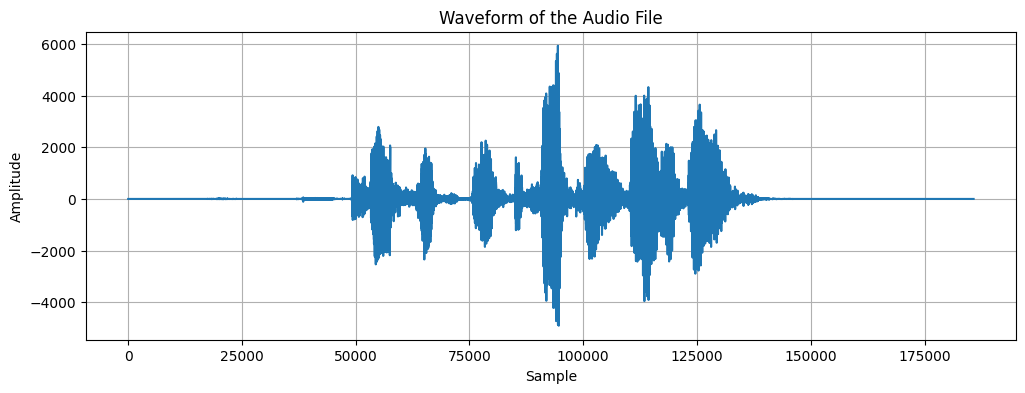

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Visualize the waveform
plt.figure(figsize=(12, 4))
# Read audio frames and convert to numpy array
with wave.open("03-01-05-01-01-01-01.wav", "rb") as wf:
    audio_frames = wf.readframes(n_frames)
    audio_data = np.frombuffer(audio_frames, dtype=np.int16)
plt.plot(audio_data)
plt.title("Waveform of the Audio File")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

**Detailed Exploratory Data Analysis (EDA)**

**Short-Time Fourier Transform (STFT) - Computation & Visualization**

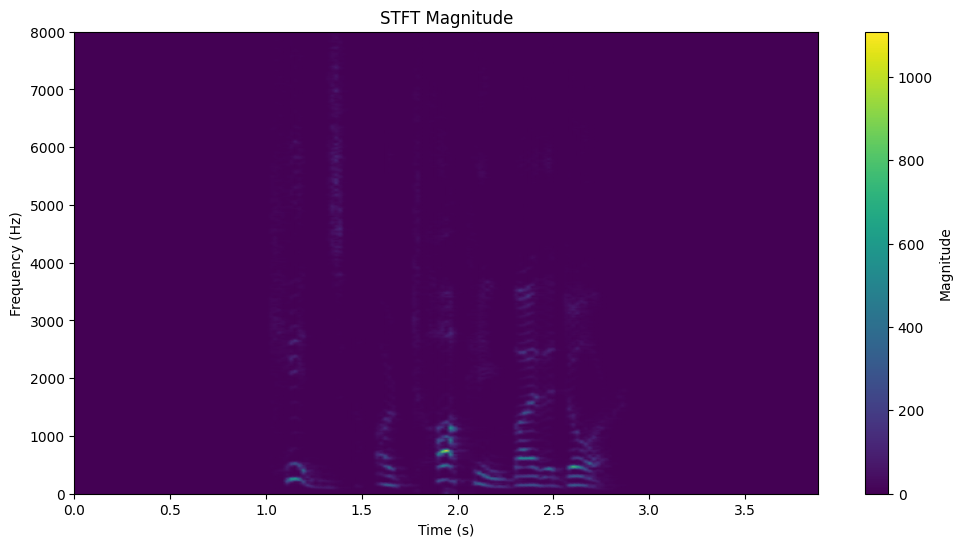

In [ ]:
from scipy.signal import stft

# Compute STFT
frequencies, times, Zxx = stft(audio_data, fs=framerate, nperseg=2048, noverlap=1024)

# Visualize STFT (magnitude)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 8000)  # Limit frequency range for better visibility
plt.show()

**Mel-frequency cepstral coefficients (MFCCs) - Computation & Visualization**

<ipython-input-6-1e46632f286a>:37: RuntimeWarning: divide by zero encountered in log
  mfccs = dct(np.log(filterbank_energies), type=2, axis=0, norm='ortho')[:13]


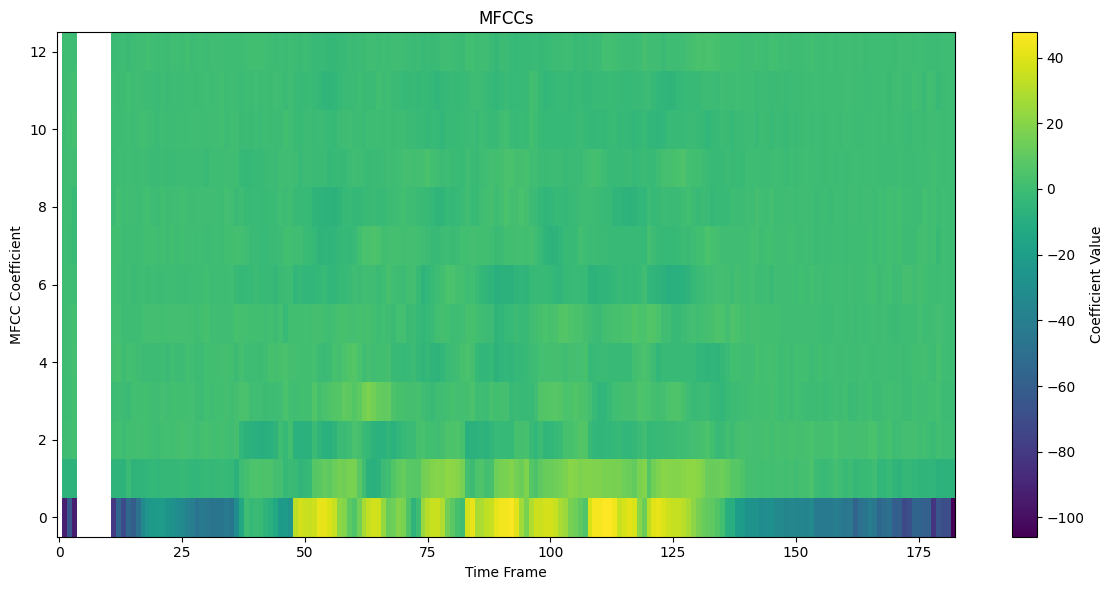

In [ ]:
from scipy.fftpack import dct

def hz_to_mel(hz):
    """Convert frequency in Hz to Mel scale."""
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    """Convert frequency in Mel scale to Hz."""
    return 700 * (10**(mel / 2595) - 1)

def mel_filterbank(num_filters, fft_size, sample_rate):
    """Generate Mel filterbank."""
    min_hz = 0
    max_mel = hz_to_mel(sample_rate / 2)
    mel_points = np.linspace(hz_to_mel(min_hz), max_mel, num_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    filters = np.zeros((num_filters, fft_size // 2 + 1))
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = \
            (np.arange(bin_points[i - 1], bin_points[i]) - bin_points[i - 1]) / (bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = \
            1 - (np.arange(bin_points[i], bin_points[i + 1]) - bin_points[i]) / (bin_points[i + 1] - bin_points[i])

    return filters

# Compute power spectrogram
power_spectrogram = np.abs(Zxx)**2

# Compute Mel filterbank energies
num_mel_filters = 40
mel_filters = mel_filterbank(num_mel_filters, 2048, framerate)
filterbank_energies = np.dot(mel_filters, power_spectrogram)

# Compute MFCCs
mfccs = dct(np.log(filterbank_energies), type=2, axis=0, norm='ortho')[:13]

# Visualize MFCCs
plt.figure(figsize=(12, 6))
plt.imshow(mfccs, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Coefficient Value')
plt.title('MFCCs')
plt.xlabel('Time Frame')
plt.ylabel('MFCC Coefficient')
plt.tight_layout()
plt.show()

**Spectrogram Visualization**

<ipython-input-7-ea013d342f5e>:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(power_spectrogram), shading='gouraud')


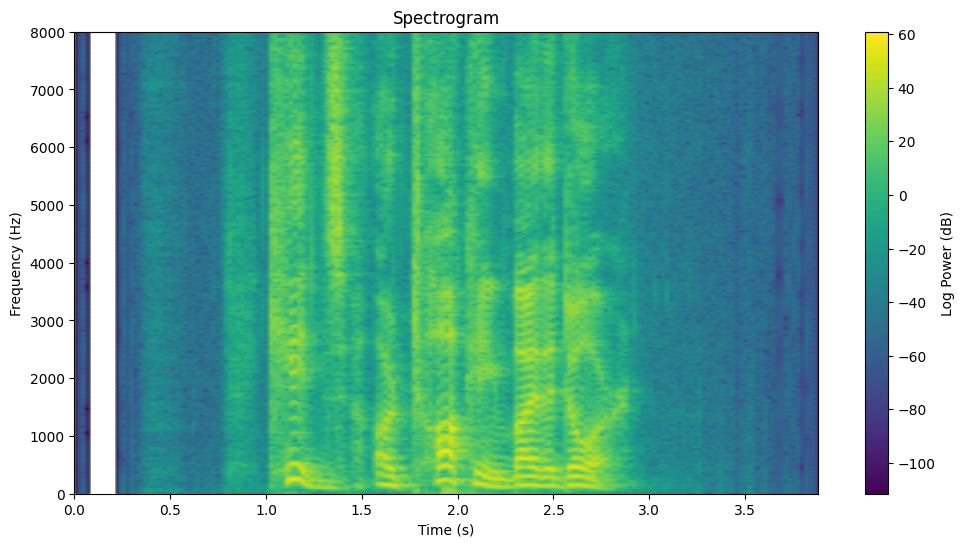

In [ ]:
# Visualize the power spectrogram (Spectrogram)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(power_spectrogram), shading='gouraud')
plt.title('Spectrogram')
plt.colorbar(label='Log Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 8000)  # Limit frequency range for better visibility
plt.show()

**Chroma Features**

<ipython-input-8-1ccdb2da6991>:3: RuntimeWarning: divide by zero encountered in log2
  return 69 + 12 * np.log2(hz / 440.0)


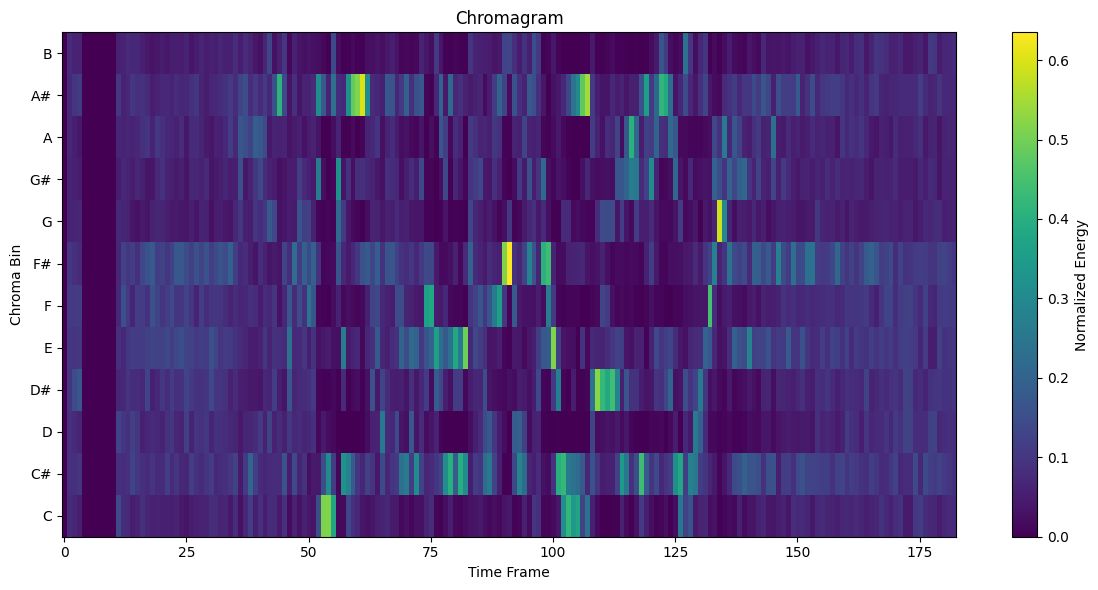

In [ ]:
def hz_to_midi(hz):
    """Convert frequency in Hz to MIDI note number."""
    return 69 + 12 * np.log2(hz / 440.0)

# Convert frequency to MIDI note number
midi_notes = hz_to_midi(frequencies)
midi_notes = np.round(midi_notes).astype(int)

# Compute chromagram
chromagram = np.zeros((12, power_spectrogram.shape[1]))
for i, note in enumerate(midi_notes):
    chroma_bin = note % 12
    chromagram[chroma_bin, :] += power_spectrogram[i, :]

# Normalize chromagram
chromagram = chromagram / (chromagram.sum(axis=0, keepdims=True) + 1e-10)

# Visualize chromagram
plt.figure(figsize=(12, 6))
plt.imshow(chromagram, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Normalized Energy')
plt.title('Chromagram')
plt.xlabel('Time Frame')
plt.ylabel('Chroma Bin')
plt.yticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.tight_layout()
plt.show()

**Normalization of the audio data**

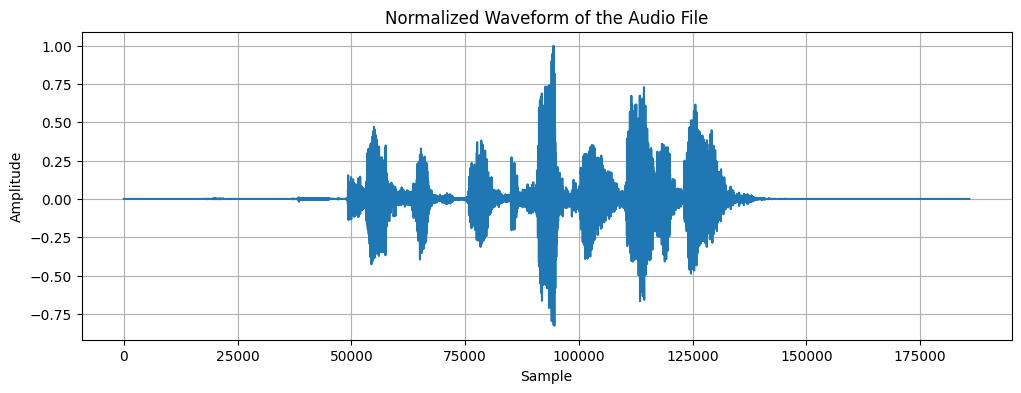

In [ ]:
# Normalize the audio data
audio_data_normalized = audio_data / np.max(np.abs(audio_data))

# Visualize the normalized waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data_normalized)
plt.title("Normalized Waveform of the Audio File")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

**Silence Removal**

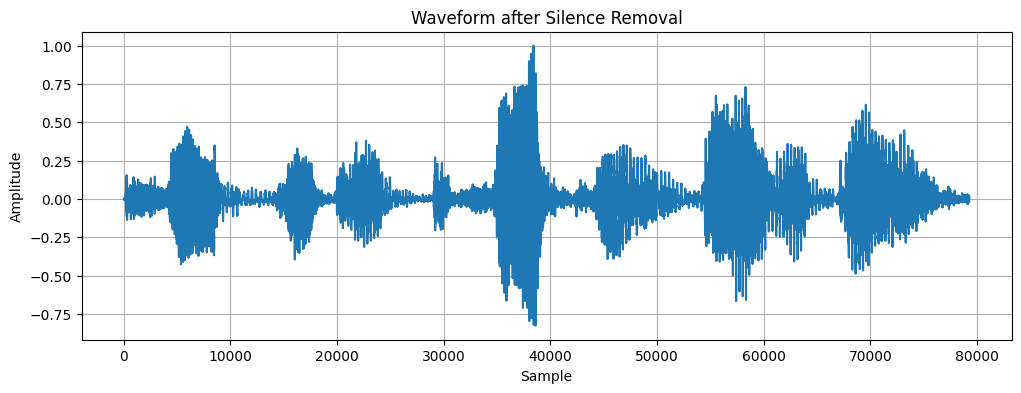

In [ ]:
def remove_silence_final(audio, sr, threshold=0.01, window_length=0.02, hop_length=0.01):
    """Remove silent segments from audio with finalized logic."""
    # Compute moving average of audio amplitude
    window_size = int(window_length * sr)
    hop_size = int(hop_length * sr)
    moving_avg = np.convolve(np.abs(audio), np.ones(window_size)/window_size, mode='same')

    # Identify non-silent regions
    non_silent = moving_avg > threshold

    # Extract non-silent segments from audio
    return audio[non_silent]

# Remove silence from the normalized audio using the finalized function
audio_no_silence = remove_silence_final(audio_data_normalized, framerate)

# Visualize the waveform after silence removal
plt.figure(figsize=(12, 4))
plt.plot(audio_no_silence)
plt.title("Waveform after Silence Removal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

**Clustering**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

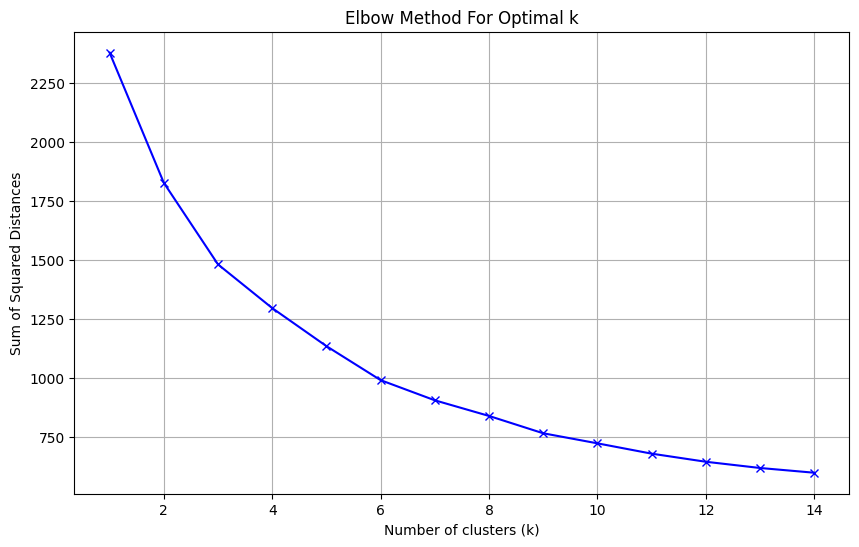

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Handle non-finite values in the MFCCs
mfccs[np.isinf(mfccs)] = np.finfo(np.float32).max
mfccs[np.isneginf(mfccs)] = np.finfo(np.float32).min
mfccs[np.isnan(mfccs)] = 0

# Standardize the MFCCs
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs.T)

# Define the range of cluster numbers to evaluate
K = range(1, 15)

# Compute the sum of squared distances for different values of k
sum_of_squared_distances = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(mfccs_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

**Clustering using MFCCs with k=3**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


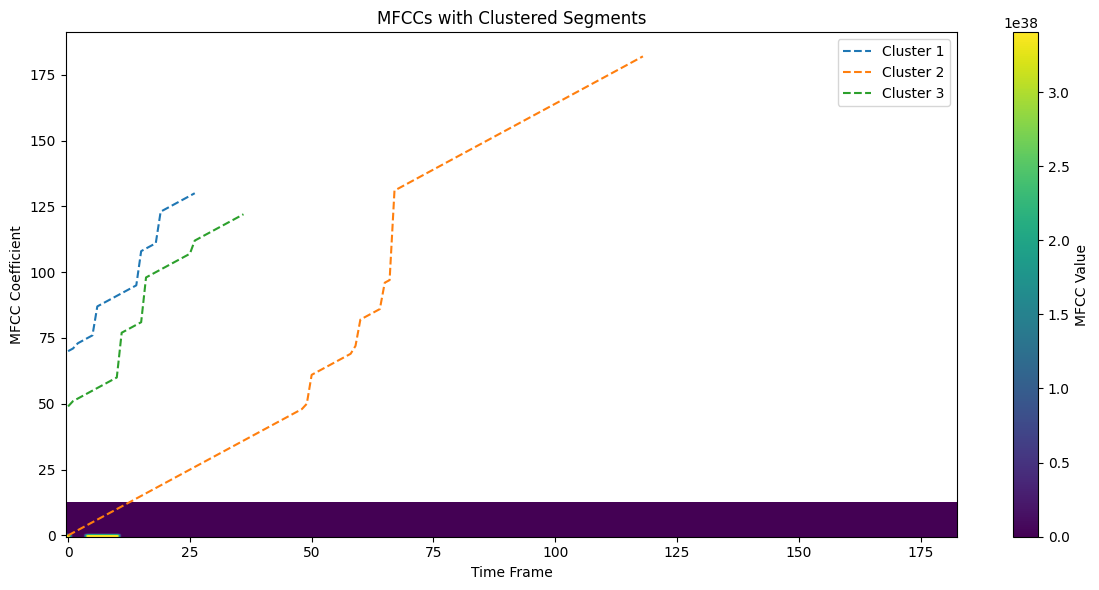

In [ ]:
# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(mfccs_scaled)

# Plot the MFCCs with cluster labels
plt.figure(figsize=(12, 6))
plt.imshow(mfccs, aspect='auto', cmap='viridis', origin='lower')
for i, label in enumerate(np.unique(cluster_labels)):
    plt.plot(np.where(cluster_labels == label)[0], label=f'Cluster {i+1}', linestyle='--')
plt.colorbar(label='MFCC Value')
plt.title('MFCCs with Clustered Segments')
plt.xlabel('Time Frame')
plt.ylabel('MFCC Coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

**Anomaly Detection using MFCCs**

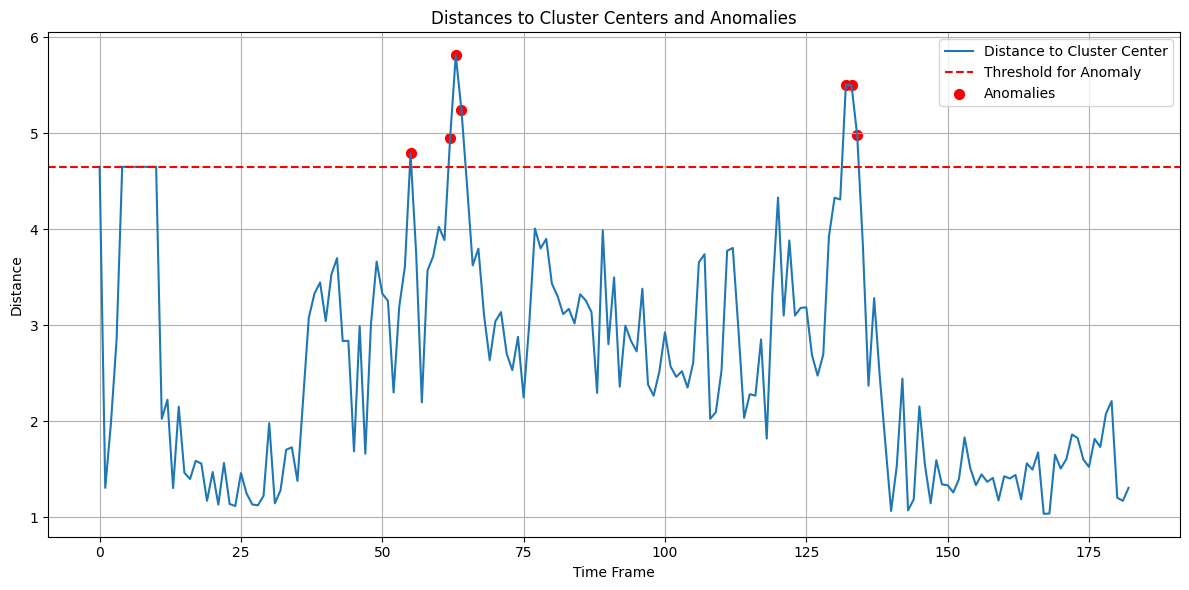

In [ ]:
# Compute the distance of each data point from its assigned cluster center
distances = np.linalg.norm(mfccs_scaled - kmeans.cluster_centers_[cluster_labels], axis=1)

# Set a threshold for anomaly detection (e.g., 95th percentile of distances)
threshold = np.percentile(distances, 95)

# Identify anomalies
anomalies = np.where(distances > threshold)[0]

# Visualize distances and anomalies
plt.figure(figsize=(12, 6))
plt.plot(distances, label='Distance to Cluster Center')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold for Anomaly')
plt.scatter(anomalies, distances[anomalies], color='red', s=50, label='Anomalies')
plt.title('Distances to Cluster Centers and Anomalies')
plt.xlabel('Time Frame')
plt.ylabel('Distance')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Feature Processing and Selection**

**Feature Extraction**

In [ ]:
import numpy as np
import librosa
import librosa.display
from librosa.feature import spectral_contrast, tonnetz
import scipy

# Extract additional features using librosa
chroma_features = np.mean(librosa.feature.chroma_stft(y=audio_no_silence, sr=framerate), axis=1)
spectral_contrast_features = np.mean(spectral_contrast(y=audio_no_silence, sr=framerate), axis=1)
tonnetz_features = np.mean(tonnetz(y=audio_no_silence, sr=framerate), axis=1)

# Aggregate MFCC features
mfcc_mean = np.mean(mfccs, axis=1)
mfcc_std = np.std(mfccs, axis=1)
mfcc_skew = scipy.stats.skew(mfccs, axis=1)

# Combine all features into a single feature vector
feature_vector = np.hstack([mfcc_mean, mfcc_std, mfcc_skew, chroma_features, spectral_contrast_features, tonnetz_features])

feature_vector.shape

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=620
  warnings.warn(


(64,)

In [ ]:
# Aggregate MFCC features without additional feature extraction
mfcc_mean = np.mean(mfccs, axis=1)
mfcc_std = np.std(mfccs, axis=1)
mfcc_skew = scipy.stats.skew(mfccs, axis=1)

# Combine aggregated features into a single feature vector
aggregated_features = np.hstack([mfcc_mean, mfcc_std, mfcc_skew])

aggregated_features.shape

(39,)

**Feature Scaling**

In [ ]:
# Standardize the aggregated features
aggregated_features_scaled = scaler.fit_transform(aggregated_features.reshape(-1, 1))

aggregated_features_scaled.T

array([[ 1.13637123, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826,  6.02676446, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826, -0.19359826,
        -0.19359826, -0.19359826, -0.19359826, -0.19359826]])

** Feature Selection using Random Forest**



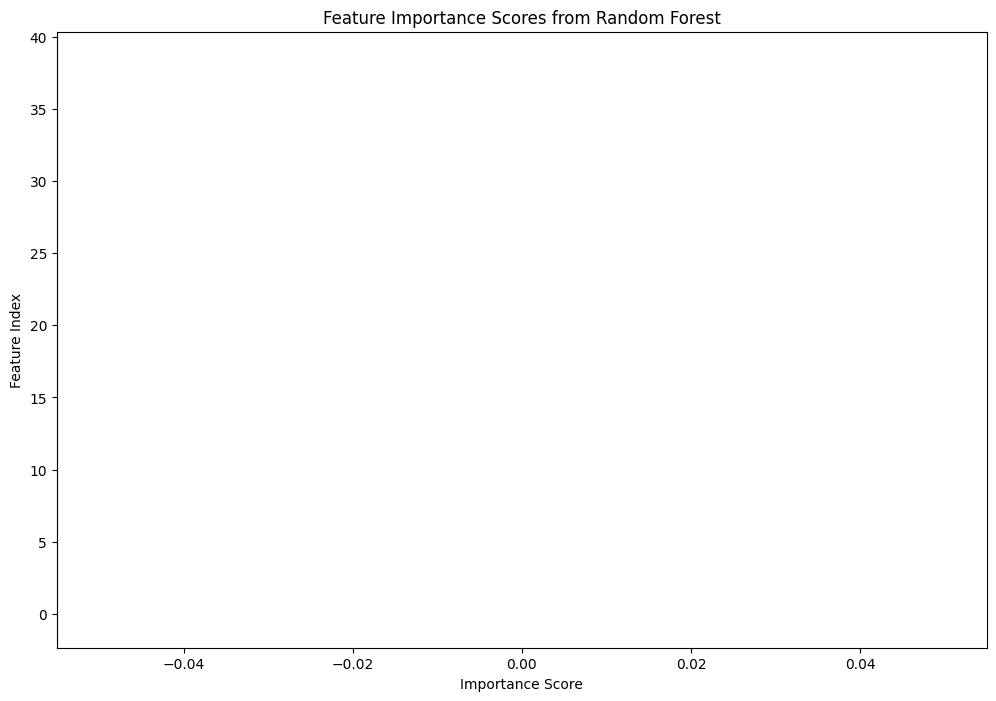

In [ ]:
# Correctly reshape the feature vector and duplicate it to create a mock dataset
from sklearn.ensemble import RandomForestRegressor
X_mock = np.tile(aggregated_features_scaled.T, (100, 1))
y_mock = np.random.rand(100)
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_mock, y_mock)

# Extract feature importance scores
feature_importances = model.feature_importances_

# Visualize the feature importance scores
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Index')
plt.title('Feature Importance Scores from Random Forest')
plt.show()

**AutoML**

** Initialize H2O**

In [ ]:
!pip install h2o
import h2o
h2o.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=f7d49fa6502e8318773d272c240f83a08f11a6cef39f2cfe2d835ded5f111724
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphfh339rb
  JVM stdout: /tmp/tmphfh339rb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphfh339rb/h2o_unknownUser_s

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_hh14y9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


**Load Data**

In [ ]:
data = h2o.import_file("03-01-05-01-01-01-01.wav")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


**Split Data**

In [ ]:
train, valid, test = data.split_frame([0.7, 0.15], seed=42)

**Set Up and Run AutoML**

In [ ]:
aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=600)
lb = aml.leaderboard
print(lb)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
H2OFrame is empty.


**View results & Make Predictions**

In [ ]:
from h2o.estimators.kmeans import H2OKMeansEstimator

# Assuming 'data' is your H2O frame
cluster_estimator = H2OKMeansEstimator(k=3)  # or any number of clusters you prefer
cluster_estimator.train(training_frame=data)

# To view the model details
print(cluster_estimator)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
Model Details
H2OKMeansEstimator : K-means
Model Key: KMeans_model_python_1698794031750_2


Model Summary: 
    number_of_rows    number_of_clusters    number_of_categorical_columns    number_of_iterations    within_cluster_sum_of_squares    total_sum_of_squares    between_cluster_sum_of_squares
--  ----------------  --------------------  -------------------------------  ----------------------  -------------------------------  ----------------------  --------------------------------
    15979             3                     1                                2                       14949                            15068                   119

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 14949.0
Total Sum of Square Error to Grand Mean: 15068.0
Between Cluster Sum of Square Error: 119.0

Centroid Statistics: 
    centroid    size    wit